Import libraries

In [34]:
import os 
import math
import pickle
import random
import json
import numpy as np
from tqdm import tqdm
from pprint import pprint 
from molmass import Formula
import rdkit.Chem as Chem
from msbuddy.utils import read_formula_str
from sklearn.linear_model import LinearRegression

import pandas as pd
from scipy.stats import pearsonr

import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
data_path = "/data/rbg/users/klingmin/projects/MS_processing/benchmarks/massspec_gym/MassSpecGym.tsv"
data = pd.read_csv(data_path, sep = "\t")
plots_folder = "./plots"
if not os.path.exists(plots_folder): os.makedirs(plots_folder)

Filter the data

In [3]:
data_CE_0 = data.loc[data.loc[:, "collision_energy"].apply(lambda x: x == 0.0), :]
data_w_CE = data.loc[data.loc[:, "collision_energy"].apply(lambda x: x!= 0.0 and not math.isnan(x)), :]
data_w_CE = data_w_CE.loc[data.loc[:, "formula"].apply(lambda x: "+" not in x and "-" not in x), :]

data_w_CE = json.loads(data_w_CE.to_json(orient = "records"))
print(len(data_w_CE))

121527


Helper Functions

In [4]:
def get_energy_bins(energy):

    if energy <= 30.0:
        return 30.0
    if energy > 30.0 and energy <= 60.0:
        return 60.0
    if energy > 60.0 and energy <= 90.0:
        return 90.0
    if energy > 90.0 and energy <= 120.0:
        return 120.0
    return 150

In [5]:
def calculate_mass(formula):

    formula_dict = read_formula_str(formula)
    total_mass = 0 

    for k, v in formula_dict.items(): 

        if k in ["Cl", "Br"]:

            if k == "Cl":
                total_mass += 35.0 * v
            
            elif k == "Br":
                total_mass += 79.0 * v

            else:
                raise Exception() 
        
        else: 
            try:
                f = Formula(k)
                f.mass
            except Exception as e:
                print(e)
                print(k)
                print(formula)
                raise Exception()
            total_mass += Formula(k).mass * v 

    return total_mass

Add theoretical mass for each of them

In [6]:
data_w_TM = [] 

for rec in tqdm(data_w_CE):
    
    instrument_type = rec["instrument_type"]
    adduct = rec["adduct"]

    measured_mass = float(rec["precursor_mz"])
    formula = rec["formula"]

    # Add on the theoretical mass and other details 
    formula_mass = calculate_mass(formula)
    if adduct == "[M+Na]+": theoretical_mass = formula_mass + 22.989769
    elif adduct == "[M+H]+": theoretical_mass = formula_mass + 1.00784
    else: 
        print(adduct)
        raise Exception()


    mass_diff = theoretical_mass - measured_mass
    rec["theoretical_mass"] = theoretical_mass
    rec["mass_diff"] = mass_diff
    
    data_w_TM.append(rec)

  0%|          | 0/121527 [00:00<?, ?it/s]

100%|██████████| 121527/121527 [00:32<00:00, 3757.64it/s]


In [7]:
mass_diff_by_instrument = {} 

for rec in tqdm(data_w_TM):
    
    instrument_type = rec["instrument_type"]
    if instrument_type is None: instrument_type = "Others"
    adduct = rec["adduct"]

    measured_mass = float(rec["precursor_mz"])
    formula = rec["formula"]
    theoretical_mass = rec["theoretical_mass"]
    mass_diff = rec["mass_diff"]

    if instrument_type not in mass_diff_by_instrument: mass_diff_by_instrument[instrument_type] = {}
    if "mass_diff" not in mass_diff_by_instrument[instrument_type]: mass_diff_by_instrument[instrument_type]["mass_diff"] = []
    if "mass" not in mass_diff_by_instrument[instrument_type]: mass_diff_by_instrument[instrument_type]["mass"] = []

    mass_diff_by_instrument[instrument_type]["mass_diff"].append(mass_diff)
    mass_diff_by_instrument[instrument_type]["mass"].append(measured_mass)

  0%|          | 0/121527 [00:00<?, ?it/s]

100%|██████████| 121527/121527 [00:00<00:00, 614541.72it/s]


Check if the distribution of mass follows a normal distribution

In [8]:
mass_distribution = {} 

for rec in data_w_TM:

    inchikey = rec["inchikey"]
    precursor_mz = rec["precursor_mz"]
    theoretical_mass = rec["theoretical_mass"]

    if inchikey not in mass_distribution:
        mass_distribution[inchikey] = {}
        mass_distribution[inchikey]["theoretical_mass"] = theoretical_mass
        mass_distribution[inchikey]["precursor_mz"] = []
    
    mass_distribution[inchikey]["precursor_mz"].append(precursor_mz)

In [44]:

for k, val in mass_distribution.items():

    unique = set(val["precursor_mz"])
    unique_rounded = [np.round(n, 2) for n in unique]

    if len(set(unique_rounded)) > 1:
        print(k)
        print(val["theoretical_mass"])
        print(unique_rounded)
    
        print()


GJSSYQDXZLZOLR
299.38803799999994
[299.18, 299.17]

AUGQEEXBDZWUJY
367.414161
[367.18, 367.17]

VOUGEZYPVGAPBB
171.17075
[171.06, 171.07]

XWIYFDMXXLINPU
329.281507
[329.07, 329.06]

AUNGANRZJHBGPY
377.372442
[377.15, 377.15, 377.15, 377.15, 377.15, 377.15, 377.14, 377.14, 377.14, 377.15]

YSMRWXYRXBRSND
369.3714829979999
[369.12, 369.13]

OIRDTQYFTABQOQ
268.24956799999995
[268.1, 268.1, 268.1, 268.11, 268.1, 268.11, 268.1, 268.1, 268.1, 268.1, 268.1, 268.1]

GNISQJGXJIDKDJ
220.20008600000003
[220.08, 220.07, 220.08, 220.08, 220.08, 220.08, 220.08]

SXTAYKAGBXMACB
181.233213
[181.07, 181.06, 181.06, 181.06, 181.06, 181.06]

GBFLZEXEOZUWRN
180.202092
[180.03, 180.03, 180.03, 180.04, 180.03]

PMMYEEVYMWASQN
132.137887
[132.07, 132.07, 132.07, 132.07, 132.07, 132.07, 132.07, 132.06, 132.07, 132.07, 132.07, 132.07, 132.07, 132.07, 132.07, 132.07]

FSYKKLYZXJSNPZ
90.10112000000001
[90.06, 90.05, 90.05, 90.06]

YBJHBAHKTGYVGT
245.318677
[245.1, 245.1, 245.1, 245.1, 245.1, 245.1, 245.09, 245.

Fit best fit lines to see the correlation of error with mass

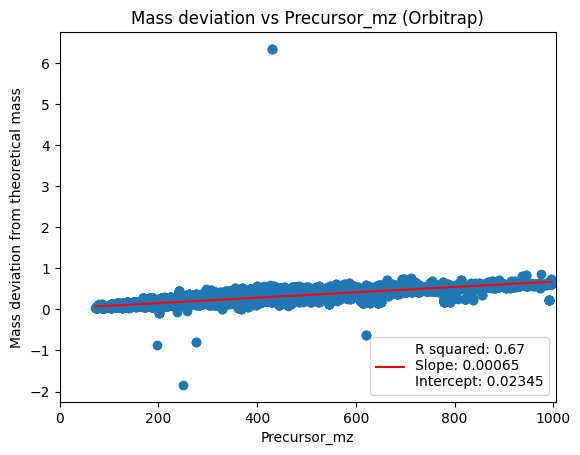

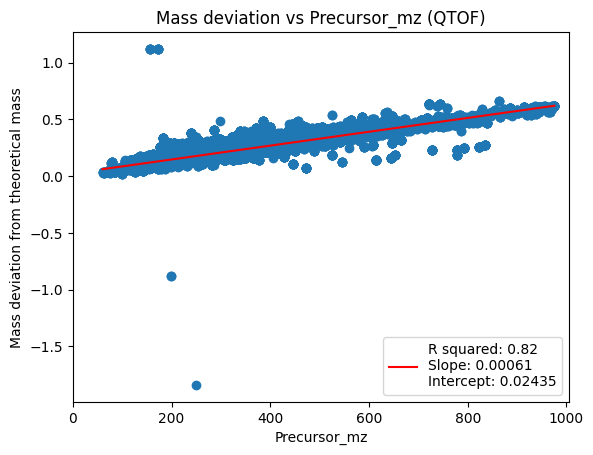

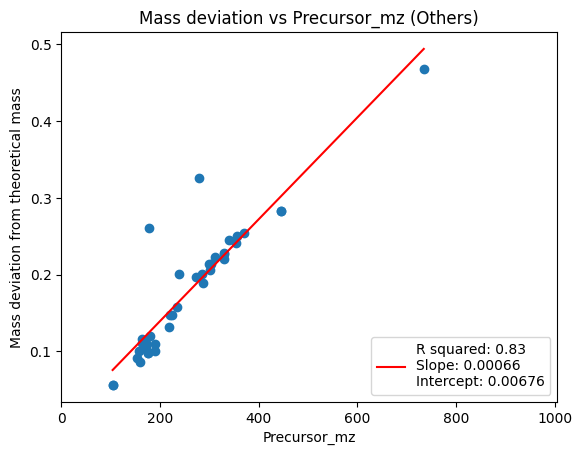

In [10]:
best_fit_params_instrument = {} 

for instrument, rec in mass_diff_by_instrument.items(): 

     # Fit a line to the rec
     slope, intercept = np.polyfit(rec["mass"], rec["mass_diff"], 1)
     best_fit_line = slope * np.array(sorted(rec["mass"])) + intercept
     correlation_value = pearsonr(rec["mass"], rec["mass_diff"])
     r_squared = correlation_value[0] ** 2

     best_fit_params_instrument[instrument] = {"slope": slope, "intercept": intercept}

     # Plot scatter plot
     plt.scatter(rec["mass"], rec["mass_diff"])
     plt.plot(sorted(rec["mass"]), best_fit_line, color='red', 
          label=f'R squared: {r_squared:.2f}\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}')

     # Add labels and title
     plt.title(f"Mass deviation vs Precursor_mz ({instrument})")
     plt.xlabel('Precursor_mz')
     plt.ylabel('Mass deviation from theoretical mass')
     plt.xlim(0, 1005)

     # Show legend
     plt.legend(loc='lower right')
     # plt.savefig(os.path.join(plots_folder, f"correlation_of_mass_error_{dataset}.png"))
     plt.show()

Get the best fit line for the combined data 

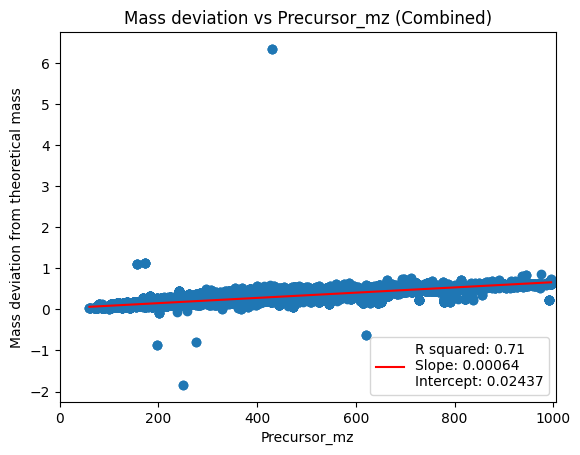

In [11]:
all_mass = [v for _, r in mass_diff_by_instrument.items() for v in r["mass"]]
all_diff = [v for _, r in mass_diff_by_instrument.items() for v in r["mass_diff"]]

# Fit a line to the rec
slope, intercept = np.polyfit(all_mass, all_diff, 1)
best_fit_line = slope * np.array(sorted(all_mass)) + intercept
correlation_value = pearsonr(all_mass, all_diff)
r_squared = correlation_value[0] ** 2
best_fit_params_instrument["all"] = {"slope": slope, "intercept": intercept}

# Plot scatter plot
plt.scatter(all_mass, all_diff)
plt.plot(sorted(all_mass), best_fit_line, color='red', 
        label=f'R squared: {r_squared:.2f}\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}')

# Add labels and title
plt.title(f"Mass deviation vs Precursor_mz (Combined)")
plt.xlabel('Precursor_mz')
plt.ylabel('Mass deviation from theoretical mass')
plt.xlim(0, 1005)

# Show legend
plt.legend(loc='lower right')
plt.savefig(os.path.join(plots_folder, f"correlation_of_mass_error_combined.png"))
plt.show()

Get different best fit lines based on energy

In [12]:
mass_diff_by_energy = {} 

for rec in tqdm(data_w_TM):
    
    energy = float(rec["collision_energy"])
    energy_bin  = get_energy_bins(energy)
    if instrument_type is None: instrument_type = "Others"
    adduct = rec["adduct"]

    measured_mass = float(rec["precursor_mz"])
    formula = rec["formula"]
    theoretical_mass = rec["theoretical_mass"]
    mass_diff = rec["mass_diff"]

    if energy_bin not in mass_diff_by_energy: mass_diff_by_energy[energy_bin] = {}
    if "mass_diff" not in mass_diff_by_energy[energy_bin]: mass_diff_by_energy[energy_bin]["mass_diff"] = []
    if "mass" not in mass_diff_by_energy[energy_bin]: mass_diff_by_energy[energy_bin]["mass"] = []

    mass_diff_by_energy[energy_bin]["mass_diff"].append(mass_diff)
    mass_diff_by_energy[energy_bin]["mass"].append(measured_mass)

100%|██████████| 121527/121527 [00:00<00:00, 547766.88it/s]


Look at how much mass deviations are there for each collision energy

0.24 0.109


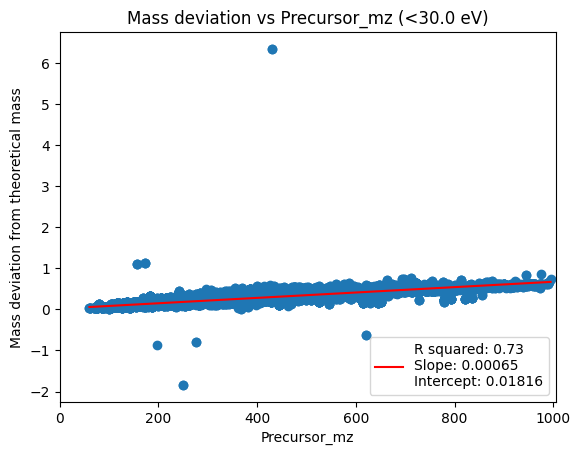

0.248 0.101


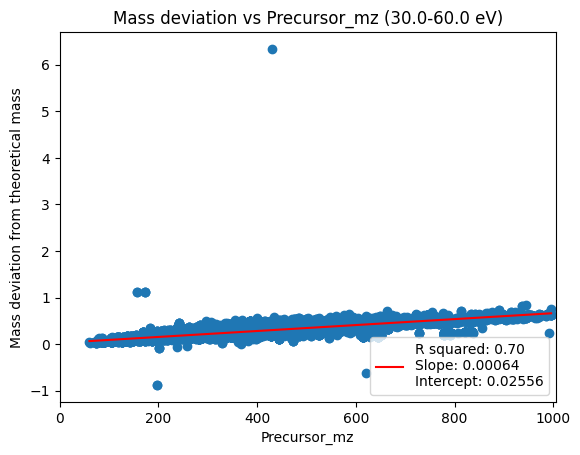

0.229 0.09


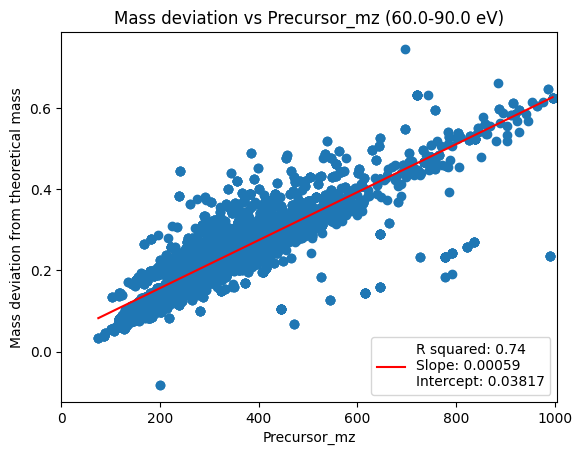

0.254 0.113


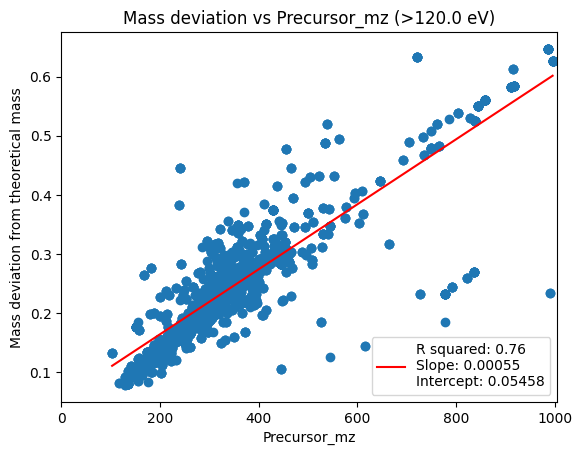

0.247 0.096


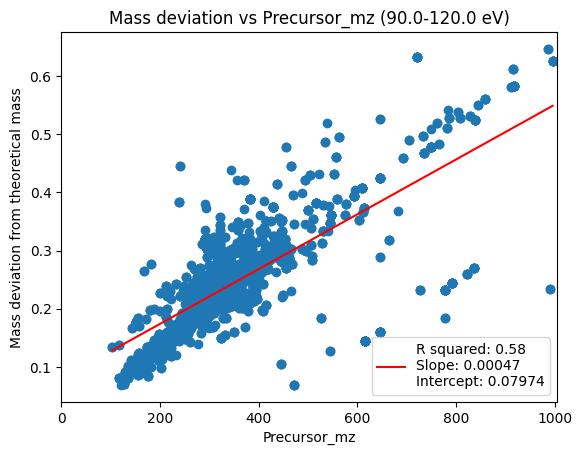

In [13]:
best_fit_params_energy = {} 

for energy, rec in mass_diff_by_energy.items(): 

   # Fit a line to the rec
   slope, intercept = np.polyfit(rec["mass"], rec["mass_diff"], 1)
   best_fit_line = slope * np.array(sorted(rec["mass"])) + intercept
   correlation_value = pearsonr(rec["mass"], rec["mass_diff"])
   r_squared = correlation_value[0] ** 2

   best_fit_params_energy[energy] = {"slope": slope, "intercept": intercept}

   # Plot scatter plot
   plt.scatter(rec["mass"], rec["mass_diff"])
   plt.plot(sorted(rec["mass"]), best_fit_line, color='red', 
      label=f'R squared: {r_squared:.2f}\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}')

   # Add labels and title
   if energy not in [30.0, 150.0]:
      text = f"{energy-30.0}-{energy} eV"
   elif energy == 30.0:
      text = f"<{energy} eV"
   elif energy == 150.0:
      text = f">{energy-30.0} eV"

   plt.title(f"Mass deviation vs Precursor_mz ({text})")
   plt.xlabel('Precursor_mz')
   plt.ylabel('Mass deviation from theoretical mass')
   plt.xlim(0, 1005)

   # Show legend
   plt.legend(loc='lower right')
   # plt.savefig(os.path.join(plots_folder, f"correlation_of_mass_error_{energy}_ev.png"))
   mean_diff, std_diff = np.round(np.mean(rec["mass_diff"]), 3), np.round(np.std(rec["mass_diff"]), 3)
   print(mean_diff, std_diff)
   plt.show()

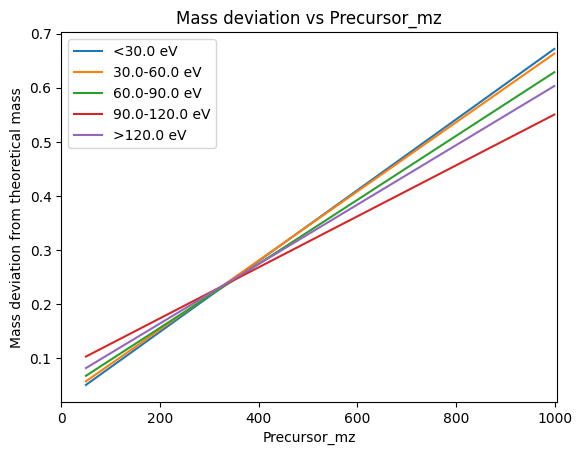

In [14]:
energy_levels = sorted(best_fit_params_energy.keys())

for energy in energy_levels:

   energy = float(energy)
   params = best_fit_params_energy[energy]
   masses = np.linspace(50, 999, 10)
   best_fit_line = params["slope"] * masses + params["intercept"]

   # Add labels and title
   if energy not in [30.0, 150.0]:
      text = f"{energy-30.0}-{energy} eV"
   elif energy == 30.0:
      text = f"<{energy} eV"
   elif energy == 150.0:
      text = f">{energy-30.0} eV"
   
   plt.plot(masses, best_fit_line,  label = text)

plt.title(f"Mass deviation vs Precursor_mz")
plt.xlabel('Precursor_mz')
plt.ylabel('Mass deviation from theoretical mass')
plt.xlim(0, 1005)
plt.legend()
# plt.savefig(os.path.join(plots_folder, f"correlation_of_mass_error_energy_combined_lines.png"))
plt.show()


Get mass deviation by chemical formula

In [15]:
mass_diff_by_formula = {} 

for rec in tqdm(data_w_TM):
    
    adduct = rec["adduct"]

    measured_mass = float(rec["precursor_mz"])
    formula = rec["formula"]
    theoretical_mass = rec["theoretical_mass"]
    mass_diff = rec["mass_diff"]

    if formula not in mass_diff_by_formula: mass_diff_by_formula[formula] = {}
    if "mass_diff" not in mass_diff_by_formula[formula]: mass_diff_by_formula[formula]["mass_diff"] = []
    if "mass" not in mass_diff_by_formula[formula]: mass_diff_by_formula[formula]["mass"] = []
    if "measured_mass" not in mass_diff_by_formula[formula]: mass_diff_by_formula[formula]["measured_mass"] = []

    mass_diff_by_formula[formula]["mass_diff"].append(mass_diff)
    mass_diff_by_formula[formula]["mass"].append(theoretical_mass)
    mass_diff_by_formula[formula]["measured_mass"].append(measured_mass)

100%|██████████| 121527/121527 [00:00<00:00, 320132.99it/s]


In [108]:
mass_diff_by_formula_params = {} 

for formula, v in mass_diff_by_formula.items(): 

    # Fit a normal distribution to the data
    mu, std = stats.norm.fit(v["measured_mass"])
    mass_diff_by_formula_params[formula] = {"mean": mu, "std": std}

In [109]:
mass_diff_by_formula_params_sorted = sorted(mass_diff_by_formula_params.items(), key=lambda item: item[1]["std"], reverse = True)
mass_diff_by_formula_params_sorted[:10]

[('C24H30N6O2', {'mean': 432.65875000000005, 'std': 2.9924641802367398}),
 ('C9H19NO2', {'mean': 173.90699863717597, 'std': 0.4304540733964083}),
 ('C16H12O5', {'mean': 285.0763715935704, 'std': 0.007703268498530701}),
 ('C18H21N3O3S', {'mean': 360.14035499999994, 'std': 0.0047025179425653095}),
 ('C13H16O4', {'mean': 237.1084666666667, 'std': 0.0045726238516774235}),
 ('C19H17ClN2O', {'mean': 325.1133, 'std': 0.0036000000000058208}),
 ('C42H72O13', {'mean': 785.502791111111, 'std': 0.003460357863437321}),
 ('C15H22N6O5S', {'mean': 399.142515, 'std': 0.0025150000000166983}),
 ('C9H15N2O15P3', {'mean': 484.97655782703333, 'std': 0.0024346652146115862}),
 ('C31H33N3O6S', {'mean': 576.2174650000001, 'std': 0.0022771638061472297})]

Get mass deviation by structure

In [115]:
mass_diff_by_structure = {} 

for rec in tqdm(data_w_CE_Hplus):

    adduct = rec["adduct"]
    if adduct != "[M+H]+": continue 

    measured_mass = float(rec["precursor_mz"])
    formula = rec["formula"]
    smiles = rec["smiles"]
    theoretical_mass = rec["theoretical_mass"]
    mass_diff = rec["mass_diff"]

    if smiles not in mass_diff_by_structure: mass_diff_by_structure[smiles] = {}
    if "mass_diff" not in mass_diff_by_structure[smiles]: mass_diff_by_structure[smiles]["mass_diff"] = []
    if "mass" not in mass_diff_by_structure[smiles]: mass_diff_by_structure[smiles]["mass"] = []
    if "measured_mass" not in mass_diff_by_structure[smiles]: mass_diff_by_structure[smiles]["measured_mass"] = []

    mass_diff_by_structure[smiles]["mass_diff"].append(mass_diff)
    mass_diff_by_structure[smiles]["mass"].append(theoretical_mass)
    mass_diff_by_structure[smiles]["measured_mass"].append(measured_mass)

100%|██████████| 118851/118851 [00:00<00:00, 237970.70it/s]


In [116]:
mass_diff_by_structrure_params = {} 

for structure, v in mass_diff_by_structure.items(): 

    # Fit a normal distribution to the data
    mu, std = stats.norm.fit(v["measured_mass"])
    mass_diff_by_structrure_params[structure] = {"mean": mu, "std": std}

In [118]:
mass_diff_by_structrure_params_sorted = sorted(mass_diff_by_structrure_params.items(), key=lambda item: item[1]["std"], reverse = True)
mass_diff_by_structrure_params_sorted[:5]

[('CC1(CC(CC(N1O)(C)C)O)C',
  {'mean': 173.47695176993332, 'std': 0.47510754934297583}),
 ('COC1=CC=C(C=C1)C2=COC3=CC(=CC(=C3C2=O)O)O',
  {'mean': 285.0776404934902, 'std': 0.013203756070501513}),
 ('C1CCC(C1)(C(=O)O)N', {'mean': 130.09175, 'std': 0.006736096792647613}),
 ('CC(=CCC[C@@](C)([C@H]1CC[C@@]2([C@@H]1[C@@H](C[C@H]3[C@]2(CC[C@@H]4[C@@]3(CC[C@@H](C4(C)C)O[C@H]5[C@@H]([C@H]([C@@H]([C@H](O5)CO)O)O)O[C@H]6[C@@H]([C@H]([C@@H]([C@H](O6)CO)O)O)O)C)C)O)C)O)C',
  {'mean': 785.5020775, 'std': 0.004317136637845057}),
 ('C1CC1CN2C(=O)CN=C(C3=C2C=CC(=C3)Cl)C4=CC=CC=C4',
  {'mean': 325.1133, 'std': 0.0036000000000058208})]

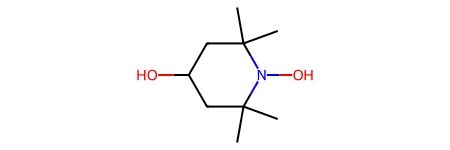

In [120]:
Chem.MolFromSmiles(mass_diff_by_structrure_params_sorted[0][0])

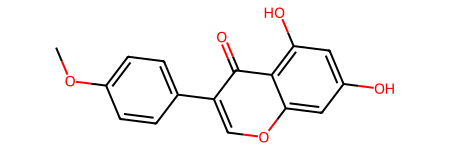

In [121]:
Chem.MolFromSmiles(mass_diff_by_structrure_params_sorted[1][0])

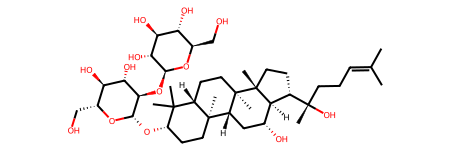

In [122]:
Chem.MolFromSmiles(mass_diff_by_structrure_params_sorted[3][0])

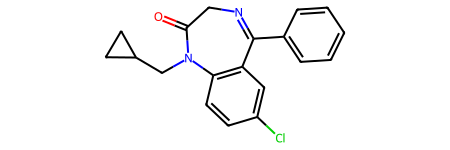

In [123]:
Chem.MolFromSmiles(mass_diff_by_structrure_params_sorted[4][0])

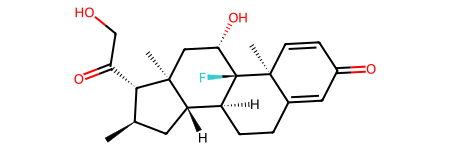

In [124]:
Chem.MolFromSmiles(mass_diff_by_structrure_params_sorted[5][0])

Understand the issue with having inaccurate mass

In [17]:
# Get train test split
train_ratio = 0.8 
n_train = int(train_ratio * len(data_w_TM))
random.shuffle(data_w_TM)

train_data, test_data = data_w_TM[:n_train], data_w_TM[n_train:]
print(len(train_data), len(test_data))

97221 24306


In [36]:
# Get the y 
train_error = np.array([r["theoretical_mass"] - float(r["precursor_mz"]) for r in train_data])
test_error = np.array([r["theoretical_mass"] - float(r["precursor_mz"]) for r in test_data])

In [20]:
formula_mass = {} 

for rec in tqdm(data_w_TM):

    adduct = rec["adduct"]

    formula = rec["formula"]
    formula_mass[formula] = calculate_mass(formula)

  0%|          | 0/121527 [00:00<?, ?it/s]

100%|██████████| 121527/121527 [00:31<00:00, 3802.97it/s]


In [50]:
correct, total, rank = 0, 0, [] 

for rec in tqdm(test_data):
    
    precursor_mz = float(rec["precursor_mz"])
    adduct = rec["adduct"]
    correct_formula = rec["formula"]

    if adduct == "[M+Na]+": precursor_mz = precursor_mz - 22.989769
    elif adduct == "[M+H]+": precursor_mz = precursor_mz - 1.00784

    current_diff = {k :abs(v-precursor_mz) for k, v in formula_mass.items()}
    all_diff_scores = list(sorted(set(current_diff.values())))
    correct_formula_diff = current_diff[correct_formula]

    index = all_diff_scores.index(correct_formula_diff)
    rank.append(index)

    if index == 0: correct += 1 
    total += 1 

acc = correct/total * 100 
print(acc)

100%|██████████| 24306/24306 [02:42<00:00, 149.98it/s]

5.385501522257878


In [54]:
def get_features(r):
    

    # Get precursor_mz 
    mass = [float(r["precursor_mz"])]

    # Get energy 
    energy = float(r["collision_energy"])
    energy_bins = [0,0,0,0,0]
    energy_bin  = get_energy_bins(energy)
    if energy_bin == 30.0: energy_bins[0] = 1 
    if energy_bin == 60.0: energy_bins[1] = 1 
    if energy_bin == 90.0: energy_bins[2] = 1 
    if energy_bin == 120.0: energy_bins[3] = 1 
    if energy_bin == 150.0: energy_bins[4] = 1 
    assert sum(energy_bins) == 1

    # Get machine 
    machine = r["instrument_type"]
    machines = [0,0,0]
    if machine == "Orbitrap": machines[0] = 1 
    if machine == "QTOF": machines[1] = 1 
    if machine is None: machines[2] = 1 
    assert sum(machines) == 1
    
    feats = mass + machines #+ energy_bins

    return feats

In [55]:
# Get the features 
train_features = [] 

for r in train_data:
    
    feats = get_features(r)
    train_features.append(feats)

train_features = np.array(train_features)
print(train_features.shape)

 

(97221, 4)


In [56]:
print("Fitting the model")
model = LinearRegression()
model.fit(train_features, train_error)
print("Fitted the model")

print(model.coef_)
print(model.intercept_)

Fitting the model
Fitted the model
[ 0.00063439  0.00972349 -0.00388062 -0.00584287]
0.019937857095893546


In [57]:
correct_corrected, total, rank_corrected = 0, 0, []

for rec in tqdm(test_data):
    
    precursor_mz = float(rec["precursor_mz"])
    adduct = rec["adduct"]
    correct_formula = rec["formula"]
    error = model.predict(np.array(get_features(r)).reshape(1,-1))[0]

    precursor_mz = precursor_mz + error

    if adduct == "[M+Na]+": precursor_mz = precursor_mz - 22.989769
    elif adduct == "[M+H]+": precursor_mz = precursor_mz - 1.00784

    current_diff = {k :abs(v-precursor_mz) for k, v in formula_mass.items()}
    all_diff_scores = list(sorted(set(current_diff.values())))
    correct_formula_diff = current_diff[correct_formula]

    index = all_diff_scores.index(correct_formula_diff)

    rank_corrected.append(index)

    if index == 0: correct_corrected += 1 
    total += 1

acc = correct_corrected/total * 100 
print(acc)

100%|██████████| 24306/24306 [04:02<00:00, 100.20it/s]

9.635480951205464


In [58]:
recall_at_k, recall_at_k_corrected = [],[] 
total = len(rank)

for k in range(0, 100, 5):

    recall_at_k.append(len([r for r in rank if r <= k])/ total * 100 )
    recall_at_k_corrected.append(len([r for r in rank_corrected if r <= k]) / total * 100)

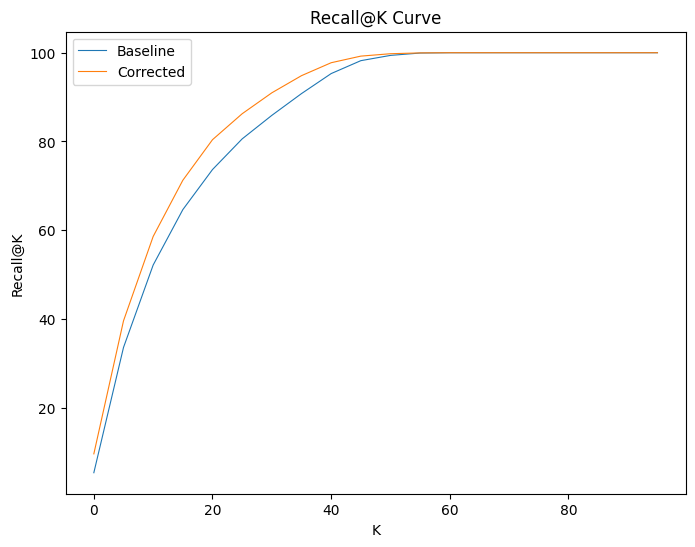

In [59]:
# Plot Recall@K curve with a thinner line
plt.figure(figsize=(8, 6))
plt.plot(range(0, 100, 5), recall_at_k, linewidth=0.8, label = "Baseline")
plt.plot(range(0, 100, 5), recall_at_k_corrected, linewidth=0.8, label = "Corrected")

# Add labels and title
plt.xlabel('K')
plt.ylabel('Recall@K')
plt.title('Recall@K Curve')
plt.legend()

# Show the plot
plt.savefig(os.path.join(plots_folder, "correction_curve_massspecgym.png"))
plt.show()

In [60]:
recall_table = pd.DataFrame({"k" : range(0, 100, 5),
                             "recall_baseline": recall_at_k, 
                             "recall_corrected": recall_at_k_corrected})

recall_table

,k,recall_baseline,recall_corrected
0,0,5.385502,9.635481
1,5,33.600757,39.599276
2,10,52.168189,58.602814
3,15,64.650704,71.266354
4,20,73.677281,80.404015
5,25,80.585041,86.250309
6,30,85.884144,90.965194
7,35,90.788283,94.828437
8,40,95.297457,97.741298
9,45,98.206204,99.230643
